Make simulate data faster using just a unique estimation for each run, and not estimate each time just a single number.

# Set Up

In [1]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from SYN_package.functions import *
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

Cloning into 'thesis'...
remote: Enumerating objects: 1078, done.
remote: Counting objects: 100% (327/327), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 1078 (delta 231), reused 282 (delta 203), pack-reused 751
Receiving objects: 100% (1078/1078), 55.87 MiB | 14.83 MiB/s, done.
Resolving deltas: 100% (674/674), done.
Updating files: 100% (57/57), done.
Mounted at /content/drive


# Model simulation

In [2]:
rd=pd.read_csv('/content/drive/MyDrive/thesis/data/reddit/reddit_labeled_data_unified_processed.csv')
fb=pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_snews_processed.csv')
vo=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_processed.csv')
yt=pd.read_csv('/content/drive/MyDrive/thesis/data/youtube/processed_sample.csv')

In [3]:
fb = fb[fb['temporal_distance_birth_h'] < 100].copy()
fb['temporal_distance_birth_base_100h'] = fb['temporal_distance_birth_h'] / 100

rd = rd[rd['temporal_distance_birth_h'] < 100].copy()
rd['comment_id']=rd['comment_code']
rd['temporal_distance_birth_base_100h'] = rd['temporal_distance_birth_h'] / 100

vo = vo[vo['temporal_distance_birth_h'] < 100].copy()
vo['temporal_distance_birth_base_100h'] = vo['temporal_distance_birth_h'] / 100
vo['post_id'] = vo['root_submission']
vo['user_id']=vo['user']

yt = yt[yt['temporal_distance_birth_h'] < 100].copy()
yt['temporal_distance_birth_base_100h'] = yt['temporal_distance_birth_h'] / 100
yt['user_id']=yt['user']

'''fbb = fbb[fbb['temporal_distance_birth_h'] < 100].copy()
fbb['temporal_distance_birth_base_100h'] = fbb['temporal_distance_birth_h'] / 100
fbb['user_id']=fbb['from_id']'''

"fbb = fbb[fbb['temporal_distance_birth_h'] < 100].copy()\nfbb['temporal_distance_birth_base_100h'] = fbb['temporal_distance_birth_h'] / 100\nfbb['user_id']=fbb['from_id']"

In [4]:
time_intervals = np.arange(0, 1.05, 0.05)  # Utilizzo di np.arange per intervalli decimali


fb_ECDF = calculate_ECDF(fb, time_intervals)
fb_ECDF['Platform']='Facebook'
rd_ECDF = calculate_ECDF(rd, time_intervals)
rd_ECDF['Platform']='Reddit'

vo_ECDF = calculate_ECDF(vo, time_intervals)
vo_ECDF['Platform']='Voat'

yt_ECDF = calculate_ECDF(yt, time_intervals)
yt_ECDF['Platform']='yt'

combined_results = pd.concat([fb_ECDF, rd_ECDF,vo_ECDF,yt_ECDF], ignore_index=True)



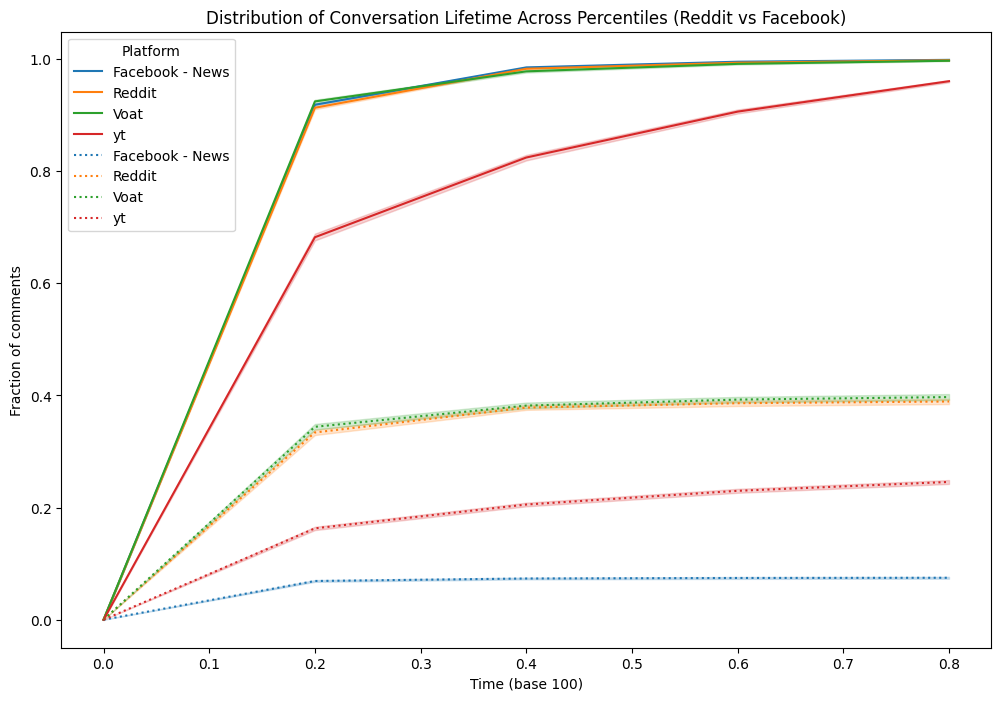

In [21]:
df=combined_results
plot_ECDF(df,level=99)

## Parameter's Choice

### T0

In [57]:
lista_dei_social=[fb,rd,yt,vo]
nomi_dei_social=['fb','rd','yt','vo']
from scipy.stats import beta

# Function to fit beta distribution and return parameters
def fit_beta_distribution(data):
    data = data[data > 0]  # Filter out zero or negative values
    a, b, loc, scale = beta.fit(data  )# ,floc=0, fscale=1)
    return {'a': a, 'b': b, 'loc': loc, 'scale': scale}

# Example data fitting for each social media platform
params_dict = {}

# Example data fitting for YouTube (yt)
print('Starting yt')
social=yt
data = social[social['sequential_number_of_comment_by_user_in_thread']==1]['temporal_distance_birth_base_100h']
data = data[data > 0]
yt_params = fit_beta_distribution(data)
params_dict['yt'] = yt_params

# Example data fitting for Facebook (fb)
print('Starting fb')
social=fb
data = social[social['sequential_number_of_comment_by_user_in_thread']==1]['temporal_distance_birth_base_100h']
data = data[data > 0]
fb_params = fit_beta_distribution(data)
params_dict['fb'] = fb_params

# Example data fitting for Reddit (rd)
print('Starting rd')
social=rd
data = social[social['sequential_number_of_comment_by_user_in_thread']==1]['temporal_distance_birth_base_100h']
data = data[data > 0]
rd_params = fit_beta_distribution(data)
params_dict['rd'] = rd_params

# Example data fitting for Voat (vo)
print('Starting vo')
social=vo
data = social[social['sequential_number_of_comment_by_user_in_thread']==1]['temporal_distance_birth_base_100h']
data = data[data > 0]
vo_params = fit_beta_distribution(data)
params_dict['vo'] = vo_params

# Display the parameters
for social, params in params_dict.items():
    print(f"{social}:")
    print(f"  Shape parameter (a): {params['a']}")
    print(f"  Shape parameter (b): {params['b']}")
    print(f"  Location parameter: {params['loc']}")
    print(f"  Scale parameter: {params['scale']}")
    print()



Starting yt


/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


Starting fb


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Starting rd
Starting vo
yt:
  Shape parameter (a): 0.5186615140672572
  Shape parameter (b): 1.7898387515641103
  Location parameter: 0.0009999999999999998
  Scale parameter: 1.1104373293304093

fb:
  Shape parameter (a): 0.3844295492882861
  Shape parameter (b): 294.47288219865607
  Location parameter: 0.0009999999999999998
  Scale parameter: 33.07578198818712

rd:
  Shape parameter (a): 1.3208418726992361
  Shape parameter (b): 366274394.2558266
  Location parameter: 0.00043188573340450587
  Scale parameter: 21377429.04281839

vo:
  Shape parameter (a): 0.7683453768943135
  Shape parameter (b): 181.35859916908146
  Location parameter: 0.0009999999999999998
  Scale parameter: 10.849357267138616



Shape parameter (a): 0.5015105408216343
Shape parameter (b): 5.630144935875129
Location parameter: 0
Scale parameter: 1


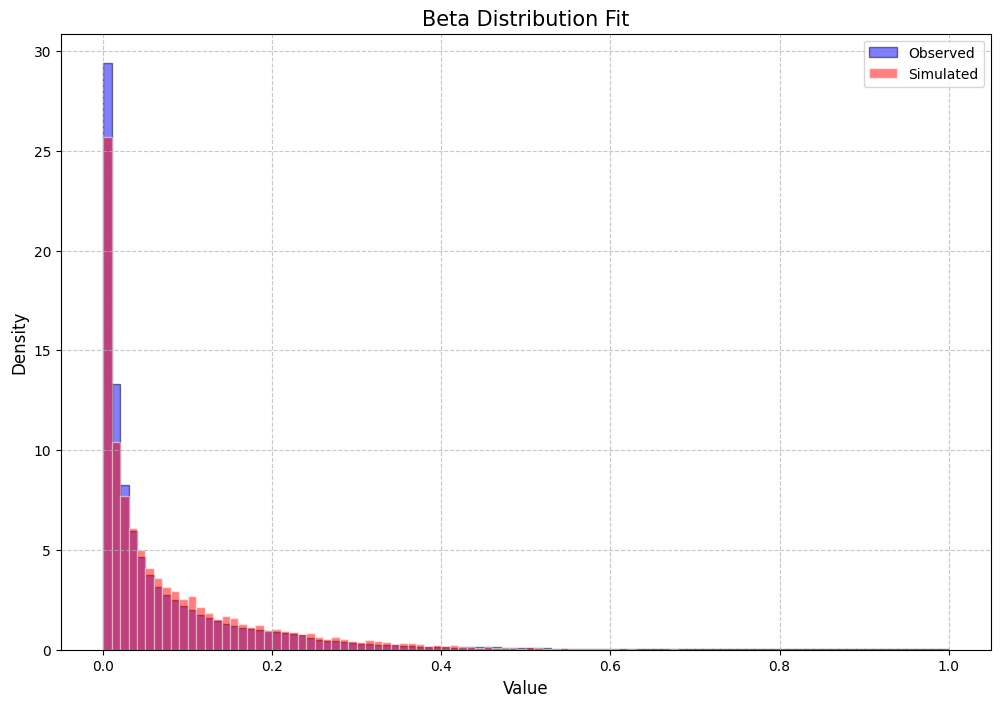

In [14]:


social=fb
data = social[social['sequential_number_of_comment_by_user_in_thread']==1]['temporal_distance_birth_base_100h']
data = data[data > 0]
a=fb_params['a']
b=fb_params['b']
loc=fb_params['loc']
scale=fb_params['scale']




simulated = beta.rvs(a, b, loc=loc, scale=scale, size=10000)
print("Shape parameter (a):", a)
print("Shape parameter (b):", b)
print("Location parameter:", loc)
print("Scale parameter:", scale)

# Plot histogram
plt.figure(figsize=(12, 8))
bins = np.linspace(0, 1, 101)
plt.hist(data, bins, alpha=0.5, label='Observed', color='blue', density=True, edgecolor='black')


plt.hist(simulated, bins, alpha=0.5, label='Simulated', color='red', density=True, edgecolor='white')


# Labels, title, legend, etc.
plt.title('Beta Distribution Fit', fontsize=15)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()



#### Observed data from different platforms

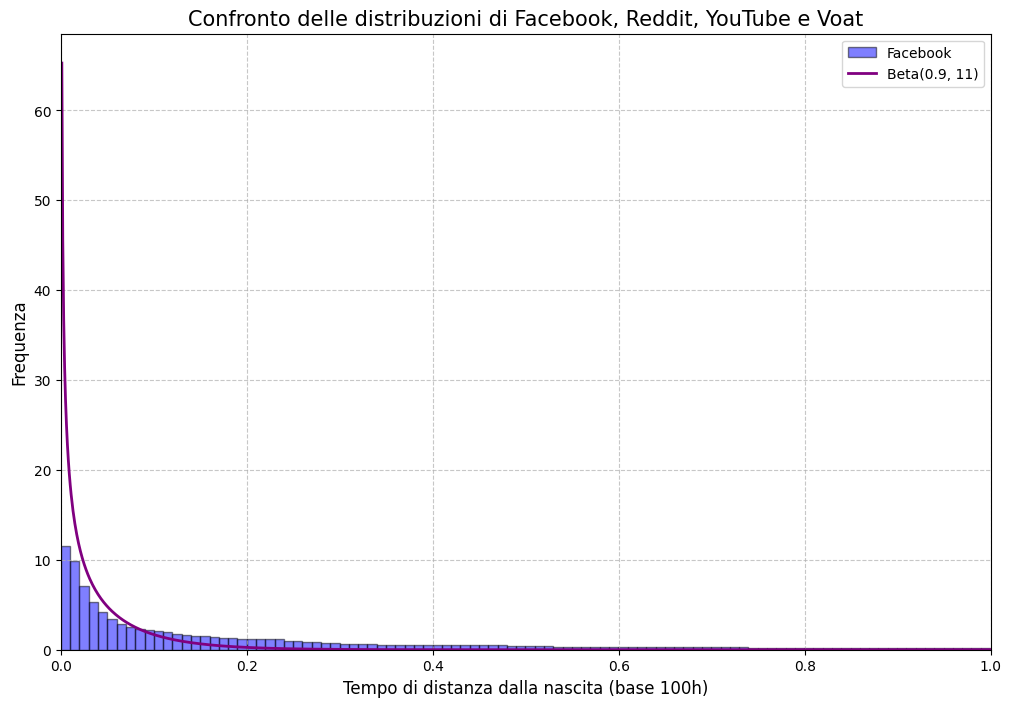

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# Assume fb, rd, yt, vo are already defined dataframes with the required data columns

plt.figure(figsize=(12, 8))

# Plot histograms for the different distributions
plt.hist(fb['temporal_distance_birth_base_100h'], bins=100, alpha=0.5, label='Facebook', color='blue', density=True, edgecolor='black')

# Generate the beta distribution with parameters alpha=0.9 and beta=11
x = np.linspace(0, 1, 1000)
beta_dist = beta.pdf(x, 0.5, 14)

# Plot the beta distribution
plt.plot(x, beta_dist, label='Beta(0.9, 11)', color='purple', linewidth=2)

# Add titles and labels
plt.title('Confronto delle distribuzioni di Facebook, Reddit, YouTube e Voat', fontsize=15)
plt.xlabel('Tempo di distanza dalla nascita (base 100h)', fontsize=12)
plt.ylabel('Frequenza', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.xlim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


#### Teoretical distributions

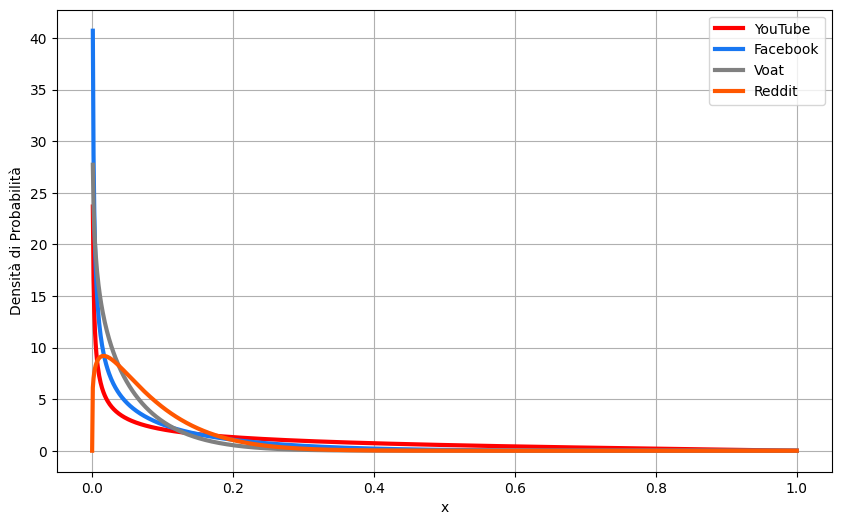

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Generiamo una griglia di valori x per il plot
x = np.linspace(0, 1, 1000)

# Calcoliamo la densità di probabilità (PDF) della distribuzione beta
pdf_beta1 = beta.pdf(x, 0.49, 1.85)
pdf_beta2 = beta.pdf(x, 0.5, 5.5)
pdf_beta3 = beta.pdf(x, 0.8, 14)
pdf_beta4 = beta.pdf(x, 1.22, 14.25)

# Plot della distribuzione beta
plt.figure(figsize=(10, 6))
plt.plot(x, pdf_beta1, color='#FF0000', lw=3, label='YouTube')   # Red for YouTube
plt.plot(x, pdf_beta2, color='#1877F2', lw=3, label='Facebook')  # Facebook blue
plt.plot(x, pdf_beta3, color='grey', lw=3, label='Voat')      # Orange for Voat
plt.plot(x, pdf_beta4, color='#FF5700', lw=3, label='Reddit')    # Reddit orange-red

plt.xlabel('x')
plt.ylabel('Densità di Probabilità')
plt.legend(loc='best')
plt.grid(True)
plt.show()


### ZIE

In [31]:
def simulate_number_of_comments(alpha, lambda_,):
    # Simula la componente inflazionata (produce 0 con probabilità alpha)
    inflate = np.random.binomial(1, alpha, 1)
    # Simula la componente contatore (distribuzione esponenziale negativa)
    counts = np.random.exponential(1/lambda_, 1)
    # Discretizza i valori esponenziali per ottenere valori di conteggio interi
    counts = np.round(counts).astype(int)
    counts[counts<0]=0
    # Combina le componenti inflazionate e di conteggio
    simulated_data = inflate * (counts)
    return simulated_data

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from statsmodels.discrete.count_model import ZeroInflatedPoisson
from sklearn.metrics import mean_squared_error

# Function to simulate data from ZIP model
def simulate_zip(alpha, lambda_, size=10000):
    # Simula la componente inflazionata (produce 0 con probabilità alpha)
    inflate = np.random.binomial(1, alpha, size)
    # Simula la componente contatore (distribuzione esponenziale negativa)
    counts = np.random.exponential(1/lambda_, size)
    # Discretizza i valori esponenziali per ottenere valori di conteggio interi
    counts = np.round(counts).astype(int)
    counts[counts<0]=0
    # Combina le componenti inflazionate e di conteggio
    simulated_data = inflate * counts
    return simulated_data

# Function to calculate KL-divergence
def kl_divergence(p, q):
    epsilon = 1e-10  # Small constant to avoid log(0)
    return np.sum(p * np.log((p + epsilon) / (q + epsilon)))


for i,social in tqdm(enumerate(lista_dei_social),total=4):
  size_of_interaction = social.groupby(['user_id', 'post_id'])['comment_id'].count().reset_index()
  observed_data =size_of_interaction['comment_id']-1
  observed_data=observed_data[observed_data<1000]
  # Grid search parameters
  alpha_range = np.linspace(0, 1, 10)  # Range of alpha values to try
  lambda_range = np.arange(0.1, 2, 0.2)  # Range of lambda values to try

  best_alpha = None
  best_lambda = None
  best_loss = np.inf

  # Perform grid search
  for alpha in (alpha_range):
      for lambda_ in lambda_range:
          # Simulate data based on current parameters
          simulated_data = simulate_zip(alpha, lambda_, size=len(observed_data))

          # Compute observed and simulated counts up to the maximum observed value
          max_value = max(np.max(observed_data), np.max(simulated_data))
          observed_counts = np.bincount(observed_data, minlength=max_value + 1)
          simulated_counts = np.bincount(simulated_data, minlength=max_value + 1)

          # Normalize distributions
          observed_distribution = observed_counts / np.sum(observed_counts)
          simulated_distribution = simulated_counts / np.sum(simulated_counts)

          # Calculate KL-divergence
          loss = kl_divergence(observed_distribution, simulated_distribution)

          # Check if current parameters give a better fit
          if loss < best_loss:
              best_loss = loss
              best_alpha = alpha
              best_lambda = lambda_
  params_dict[nomi_dei_social[i]]['alpha']=best_alpha
  params_dict[nomi_dei_social[i]]['lambda']=best_lambda
  print(best_loss)



 25%|██▌       | 1/4 [00:41<02:04, 41.66s/it]

0.017813360864488956


 50%|█████     | 2/4 [00:49<00:43, 21.55s/it]

0.026417466158129378


 75%|███████▌  | 3/4 [01:23<00:27, 27.42s/it]

0.02336321011321908


100%|██████████| 4/4 [01:25<00:00, 21.25s/it]

0.04530537757249925


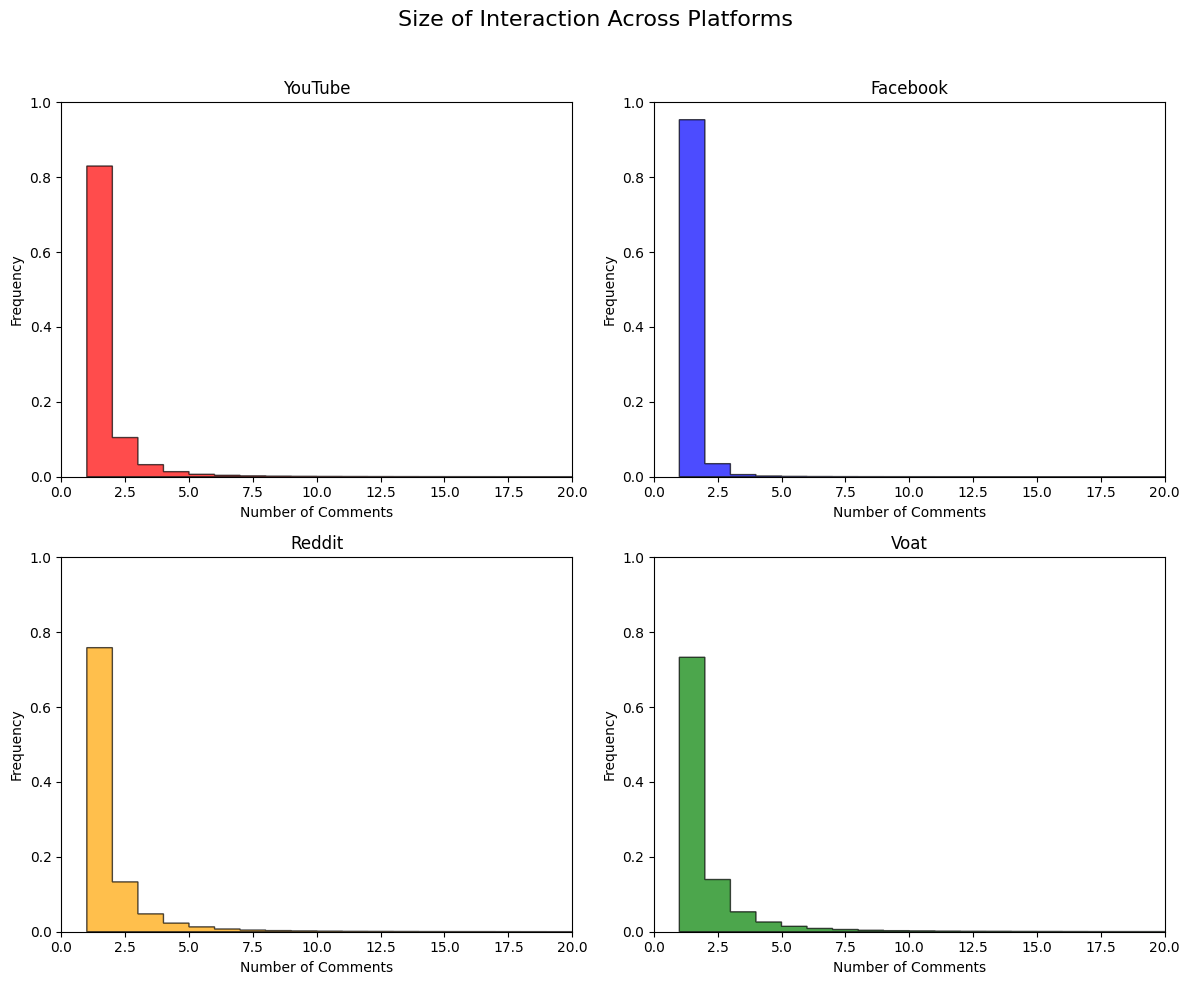

In [ ]:
bins = np.arange(1, 1000)

# Creare subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# YouTube
axs[0, 0].hist(yt_size_of_interaction, bins=bins, alpha=0.7, edgecolor='black', color='red', histtype='stepfilled', density=True)
axs[0, 0].set_title('YouTube')
axs[0, 0].set_xlim(0, 20)
axs[0, 0].set_xlabel('Number of Comments')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_ylim(0, 1)

# Facebook
axs[0, 1].hist(fb_size_of_interaction, bins=bins, alpha=0.7, edgecolor='black', color='blue', histtype='stepfilled', density=True)
axs[0, 1].set_title('Facebook')
axs[0, 1].set_xlabel('Number of Comments')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_xlim(0, 20)
axs[0, 1].set_ylim(0, 1)

# Reddit
axs[1, 0].hist(rd_size_of_interaction, bins=bins, alpha=0.7, edgecolor='black', color='orange', histtype='stepfilled', density=True)
axs[1, 0].set_title('Reddit')
axs[1, 0].set_xlim(0, 20)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlabel('Number of Comments')
axs[1, 0].set_ylabel('Frequency')

# Voat
axs[1, 1].hist(vo_size_of_interaction, bins=bins, alpha=0.7, edgecolor='black', color='green', histtype='stepfilled', density=True)
axs[1, 1].set_title('Voat')
axs[1, 1].set_xlim(0, 20)
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_xlabel('Number of Comments')
axs[1, 1].set_ylabel('Frequency')

# Titolo principale e layout
fig.suptitle('Size of Interaction Across Platforms', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

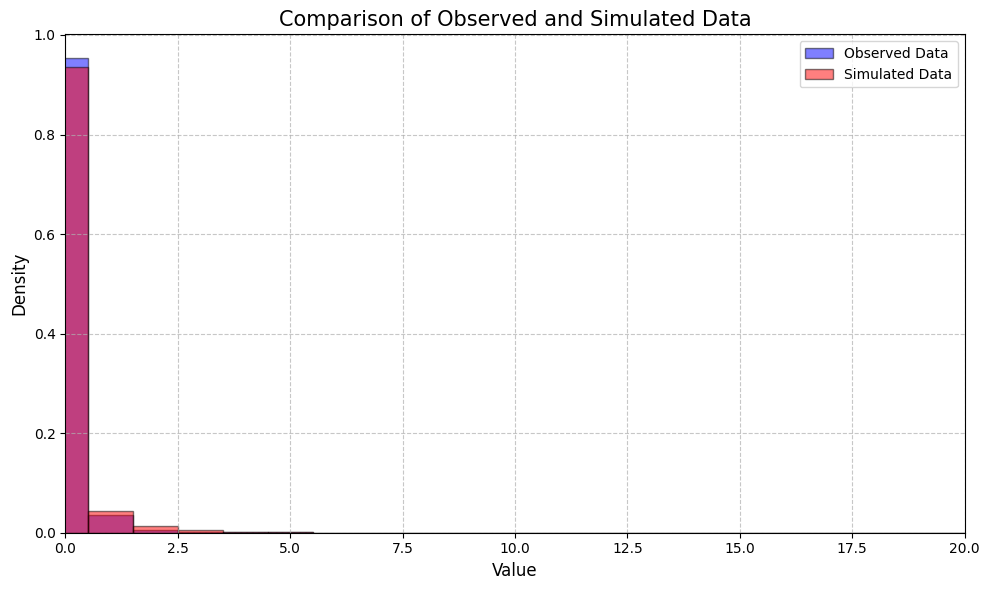

In [39]:
# Simulate data with best parameters
best_alpha = params_dict['fb']['alpha']
best_lambda = params_dict['fb']['lambda']

size_of_interaction = fb.groupby(['user_id', 'post_id'])['comment_id'].count().reset_index()
observed_data =size_of_interaction['comment_id']-1
observed_data=observed_data[observed_data<1000]

simulated_data = simulate_zip(best_alpha, best_lambda, size=len(observed_data))

# Plotting
plt.figure(figsize=(10, 6))

# Plot observed data
plt.hist(observed_data, bins=np.arange(-0.5, np.max(observed_data) + 1.5, 1), alpha=0.5, label='Observed Data', color='blue', density=True, edgecolor='black')

# Plot simulated data
plt.hist(simulated_data, bins=np.arange(-0.5, np.max(observed_data) + 1.5, 1), alpha=0.5, label='Simulated Data', color='red', density=True, edgecolor='black')

# Labels, title, legend, etc.
plt.title('Comparison of Observed and Simulated Data', fontsize=15)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0,20)
plt.tight_layout()
plt.show()

### IAT

In [62]:
import pandas as pd

def process_platform(df, platform_name):
  df['last_comment']=df['sequential_number_of_comment_by_user_in_thread']==df['number_of_comments_by_user_in_thread'].copy()
  df=df.dropna(subset='IAT_user_thread').copy()
  df['time_difference']=df['IAT_user_thread']/(60*60*100)
  merged_df=df[df['last_comment']==False].copy()
  merged_df_final=df[df['last_comment']==True].copy()
  return merged_df,merged_df_final

# Process Facebook
IAT_fb,IAT_f_fb = process_platform(fb, 'Facebook')

# Process Reddit
IAT_rd,IAT_f_rd = process_platform(rd, 'Reddit')

# Process YouTube
yt['user_id']=yt['user']
IAT_yt,IAT_f_yt = process_platform(yt, 'YouTube')

# Process Voat
vo['user_id']=vo['user']
vo['post_id']=vo['root_submission']
IAT_vo,IAT_f_vo = process_platform(vo, 'Voat')



In [63]:
import pandas as pd
import numpy as np
from scipy.stats import burr
import matplotlib.pyplot as plt

# Supponiamo che 'merged_rd' sia il DataFrame e 'time_difference' la colonna contenente i dati osservati

# Step 1: Normalizzare i dati (come hai fatto prima)
for i,IAT in tqdm(enumerate([(IAT_fb,IAT_f_fb),(IAT_rd,IAT_f_rd),(IAT_yt,IAT_f_yt),(IAT_vo,IAT_f_vo)]),total=4):
  data = IAT[0]['time_difference']
  data = data[data > 0]  # Rimuovere i valori non positivi
  data_min = data.min()
  data_max = data.max()
  c, d, l, s = burr.fit(data)

  data = IAT[1]['time_difference']
  data = data[data > 0]  # Rimuovere i valori non positivi
  data_min = data.min()
  data_max = data.max()
  cf,df,lf,sf= burr.fit(data)

  params_dict[nomi_dei_social[i]]['c']=c
  params_dict[nomi_dei_social[i]]['d']=d
  params_dict[nomi_dei_social[i]]['l']=l
  params_dict[nomi_dei_social[i]]['s']=s

  params_dict[nomi_dei_social[i]]['cf']=cf
  params_dict[nomi_dei_social[i]]['df']=df
  params_dict[nomi_dei_social[i]]['lf']=lf
  params_dict[nomi_dei_social[i]]['sf']=sf





100%|██████████| 4/4 [04:26<00:00, 66.69s/it]


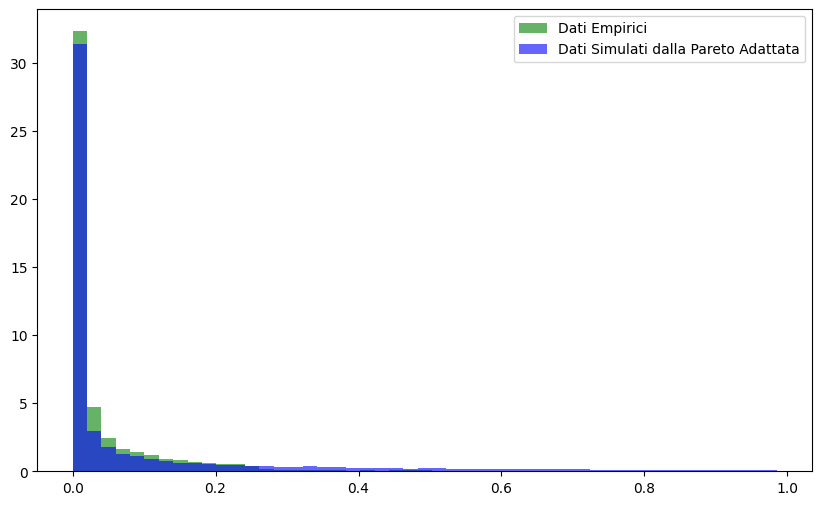

Loss: 31.700749479847808


In [50]:
# Step 3: Generare dati sintetici dalla distribuzione Burr adattata
synthetic_data = burr.rvs(params_dict['fb']['c'], params_dict['fb']['d'], params_dict['fb']['l'], params_dict['fb']['s'], size=len(data))


# Step 4: Tracciare gli istogrammi con gli stessi bin
plt.figure(figsize=(10, 6))
# Definire i bin basati sull'intervallo dei dati empirici
bins = np.linspace(data_min, data_max, 50)
# Calcola gli istogrammi e le densità
hist_empirical, _ = np.histogram(IAT_fb['time_difference'], bins=bins, density=True)
hist_synthetic, _ = np.histogram(synthetic_data, bins=bins, density=True)

# Calcola la loss come somma delle differenze di frequenza assolute
loss = np.sum(np.abs(hist_empirical - hist_synthetic))

# Visualizza gli istogrammi
plt.hist(data, bins=bins, density=True, alpha=0.6, color='g', label='Dati Empirici')
plt.hist(synthetic_data, bins=bins, density=True, alpha=0.6, color='b', label='Dati Simulati dalla Pareto Adattata')
plt.legend()
plt.show()

print(f'Loss: {loss}')


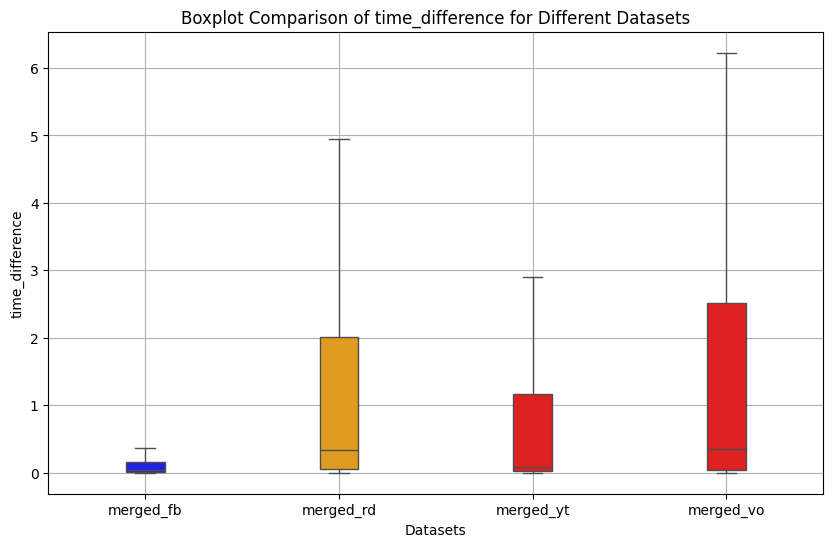

0.3480833333333333

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your data loaded correctly into DataFrames: merged_fb, merged_vo, merged_rd, merged_yt
# Each DataFrame has a column 'time_difference'

# Create a figure and axes
plt.figure(figsize=(10, 6))

# Adjust the positions for each boxplot
positions = [0,1, 2,3]  # Adjust these positions as needed

# Boxplot for merged_fb
sns.boxplot(x=positions[0], y='time_difference', data=merged_fb, color='blue', width=0.2,showfliers=False)

# Boxplot for merged_rd
sns.boxplot(x=positions[1], y='time_difference', data=merged_rd, color='orange', width=0.2,showfliers=False)

# Boxplot for merged_yt
sns.boxplot(x=positions[2], y='time_difference', data=merged_yt, color='red', width=0.2,showfliers=False)

# Boxplot for merged_yt
sns.boxplot(x=positions[3], y='time_difference', data=merged_vo, color='red', width=0.2,showfliers=False)

# Customizing the appearance of the plot
plt.title('Boxplot Comparison of time_difference for Different Datasets')
plt.xlabel('Datasets')
plt.ylabel('time_difference')
plt.xticks(positions, ['merged_fb', 'merged_rd', 'merged_yt', 'merged_vo'])  # Assign labels to positions
plt.grid(True)

# Show the plot
plt.show()

merged_fb['time_difference'].median()

merged_rd['time_difference'].median()

merged_yt['time_difference'].median()

merged_vo['time_difference'].median()



## Manual simulation

### Parameters FB

In [87]:
n=1000
parameters=params_dict['fb']

a=parameters['a']
b= parameters['b']
loc=parameters['loc']
scale=parameters['scale']

alpha=parameters['alpha']
lambda_=parameters['lambda']

c=parameters['c']
d=parameters['d']
l=parameters['l']
s=parameters['s']

cf=parameters['cf']
df=parameters['df']
lf=parameters['lf']
sf=parameters['sf']

simulated, observed=simulate_data(fb, a, b,loc,scale, alpha, lambda_,c,d,l,s,cf,df,lf,sf,num_threads=n)

100%|██████████| 1000/1000 [08:59<00:00,  1.85it/s]


In [88]:
time_intervals = np.arange(0, 1, 0.01)  # Utilizzo di np.arange per intervalli decimali

simulated_ECDF = calculate_ECDF(simulated, time_intervals)
simulated_ECDF['Platform']='Simulated'
observed_ECDF = calculate_ECDF(observed, time_intervals)
observed_ECDF['Platform']='Observed'

Processing DataFrame: 100%|██████████| 1000/1000 [01:52<00:00,  8.93it/s]


In [89]:
combined_results = pd.concat([simulated_ECDF, observed_ECDF], ignore_index=True)
error = calculate_loss(simulated_ECDF, observed_ECDF)
print('The error is equal to: ' + str(round(error, 2)))
print(len(simulated)/len( observed))

The error is equal to: 12048.09
1.0914591175510064


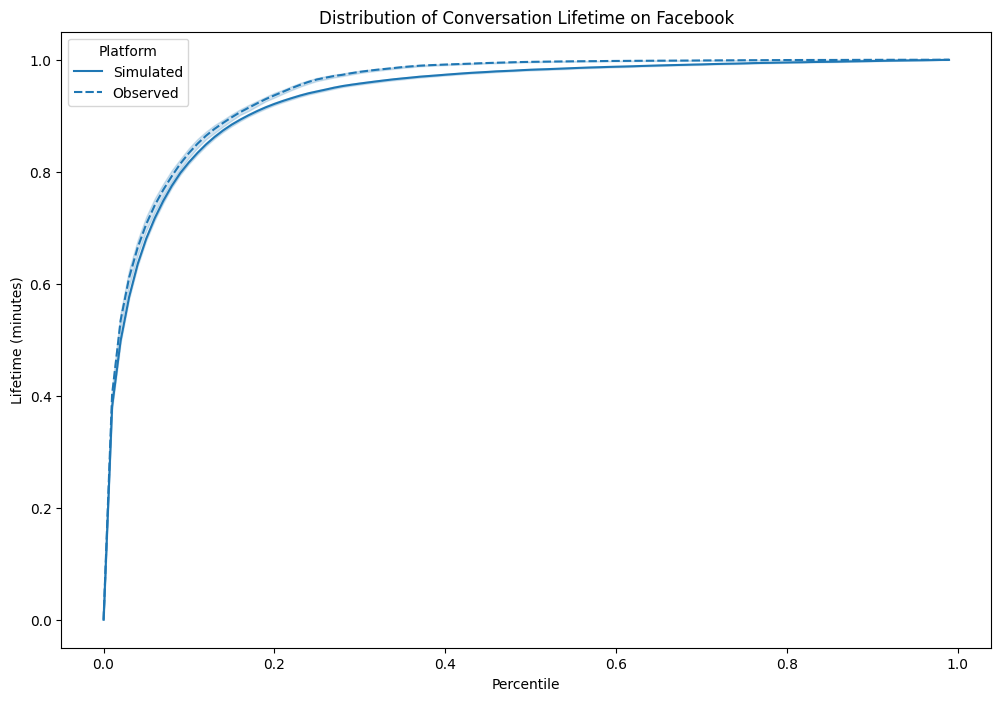

In [96]:
df = pd.concat([simulated_ECDF, observed_ECDF], ignore_index=True)
# Plotting lineplot for both Reddit and Facebook with confidence intervals
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Time Grid Value', y='Share',style='Platform', errorbar=('ci', 99))
#sns.lineplot(data=df, x='Time Grid Value', y='Share_cc',hue='Platform', errorbar=('ci', 99))
plt.title('Distribution of Conversation Lifetime on Facebook')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()
# con a,b uguale a 0.8,20

### Parameters YT

In [68]:
n=100
parameters=params_dict['yt']

a=parameters['a']
b= parameters['b']
loc=parameters['loc']
scale=parameters['scale']

alpha=parameters['alpha']
lambda_=parameters['lambda']

c=parameters['c']
d=parameters['d']
l=parameters['l']
s=parameters['s']

cf=parameters['cf']
df=parameters['df']
lf=parameters['lf']
sf=parameters['sf']

simulated, observed=simulate_data(yt, a, b,loc,scale, alpha, lambda_,c,d,l,s,cf,df,lf,sf,num_threads=n)

100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


In [69]:
simulated_ECDF = calculate_ECDF(simulated, time_intervals)
simulated_ECDF['Platform']='Simulated'
observed_ECDF = calculate_ECDF(observed, time_intervals)
observed_ECDF['Platform']='observed'

combined_results = pd.concat([simulated_ECDF, observed_ECDF], ignore_index=True)


Processing DataFrame: 100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


In [70]:
error = calculate_loss(simulated_ECDF, observed_ECDF)
print('The error is equal to: ' + str(round(error, 2)))
print(len(simulated)/len( observed))

The error is equal to: 2404.06
0.8601959311328131


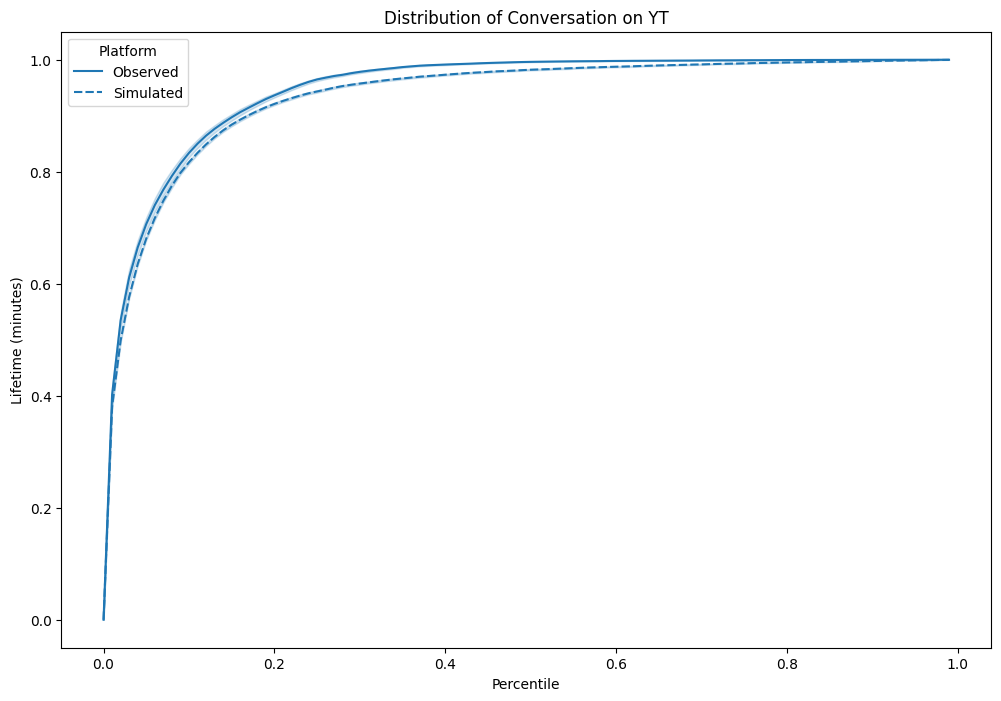

In [94]:

# Concatenate all ECDF data into one DataFrame
combined_results = pd.concat([ observed_ECDF, simulated_ECDF], ignore_index=True)
combined_results['Style']=combined_results['Platform']
# Plotting lineplot for all platforms with confidence intervals
plt.figure(figsize=(12, 8))
sns.lineplot(data=combined_results, x='Time Grid Value', y='Share',errorbar=('ci', 99), style='Style')
#sns.lineplot(data=combined_results, x='Time Grid Value', y='Share_cc', hue='Platform',errorbar=('ci', 99), style='Style')
plt.title('Distribution of Conversation on YT')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()

### Parameters Vo

In [72]:
n=100
parameters=params_dict['vo']

a=parameters['a']
b= parameters['b']
loc=parameters['loc']
scale=parameters['scale']

alpha=parameters['alpha']
lambda_=parameters['lambda']

c=parameters['c']
d=parameters['d']
l=parameters['l']
s=parameters['s']

cf=parameters['cf']
df=parameters['df']
lf=parameters['lf']
sf=parameters['sf']

simulated, observed=simulate_data(vo, a, b,loc,scale, alpha, lambda_,c,d,l,s,cf,df,lf,sf)

100%|██████████| 100/100 [00:01<00:00, 75.74it/s]


In [73]:
simulated_ECDF = calculate_ECDF(simulated, time_intervals)
simulated_ECDF['Platform']='Simulated'
observed_ECDF = calculate_ECDF(observed, time_intervals)
observed_ECDF['Platform']='Voat'

combined_results = pd.concat([simulated_ECDF, observed_ECDF], ignore_index=True)


Processing DataFrame: 100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


In [74]:
error = calculate_loss(simulated_ECDF, observed_ECDF)
print('The error is equal to: ' + str(round(error, 2)))
print(len(simulated)/len( observed))

The error is equal to: 1651.42
1.0593175153292456


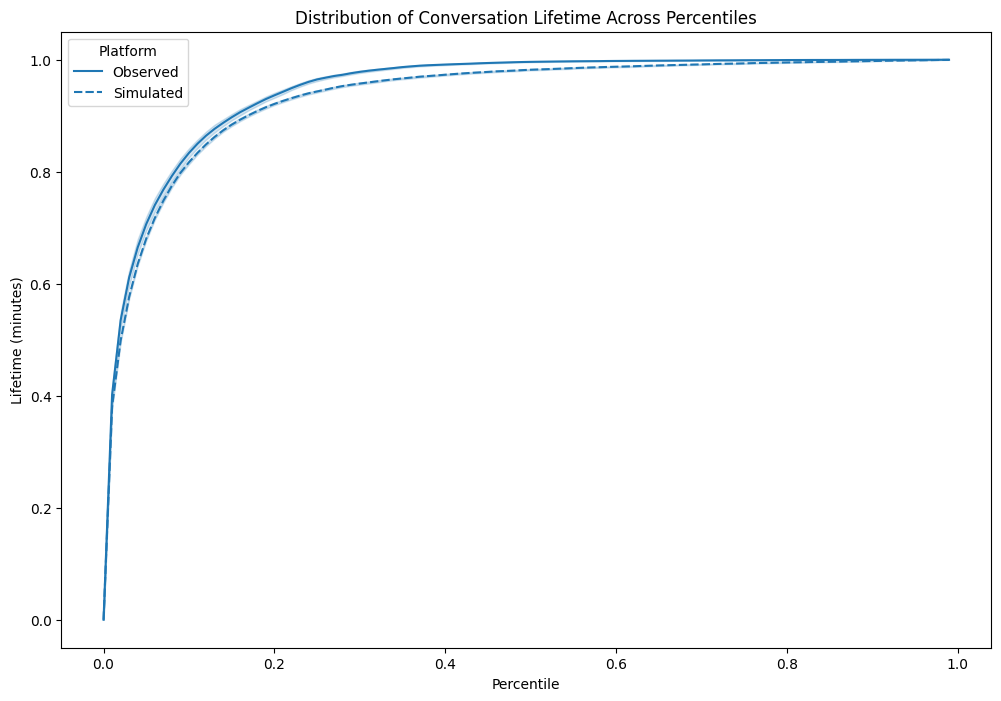

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming observed_ECDF and simulated_ECDF are already defined DataFrames

# Concatenate the ECDF data into one DataFrame
combined_results = pd.concat([observed_ECDF, simulated_ECDF], ignore_index=True)

# Plotting lineplot for all platforms with confidence intervals
plt.figure(figsize=(12, 8))
sns.lineplot(data=combined_results, x='Time Grid Value', y='Share', style='Platform', errorbar=('ci', 99))
#sns.lineplot(data=combined_results, x='Time Grid Value', y='Share_cc', hue='Platform', errorbar=('ci', 99))

plt.title('Distribution of Conversation on Voat')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')



plt.show()

### Parameters RD

In [76]:
n=100
parameters=params_dict['rd']

a=parameters['a']
b= parameters['b']
loc=parameters['loc']
scale=parameters['scale']

alpha=parameters['alpha']
lambda_=parameters['lambda']

c=parameters['c']
d=parameters['d']
l=parameters['l']
s=parameters['s']

cf=parameters['cf']
df=parameters['df']
lf=parameters['lf']
sf=parameters['sf']

simulated, observed=simulate_data(rd, a, b,loc,scale, alpha, lambda_,c,d,l,s,cf,df,lf,sf)

100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


In [78]:
simulated_ECDF = calculate_ECDF(simulated, time_intervals)
simulated_ECDF['Platform']='Simulated'
observed_ECDF = calculate_ECDF(observed, time_intervals)
observed_ECDF['Platform']='Reddit'

combined_results = pd.concat([simulated_ECDF, observed_ECDF], ignore_index=True)


Processing DataFrame: 100%|██████████| 100/100 [00:10<00:00,  9.32it/s]


In [79]:
error = calculate_loss(simulated_ECDF, observed_ECDF)
print('The error is equal to: ' + str(round(error, 2)))
print(len(simulated)/len( observed))

The error is equal to: 1851.9
1.1484446617368453


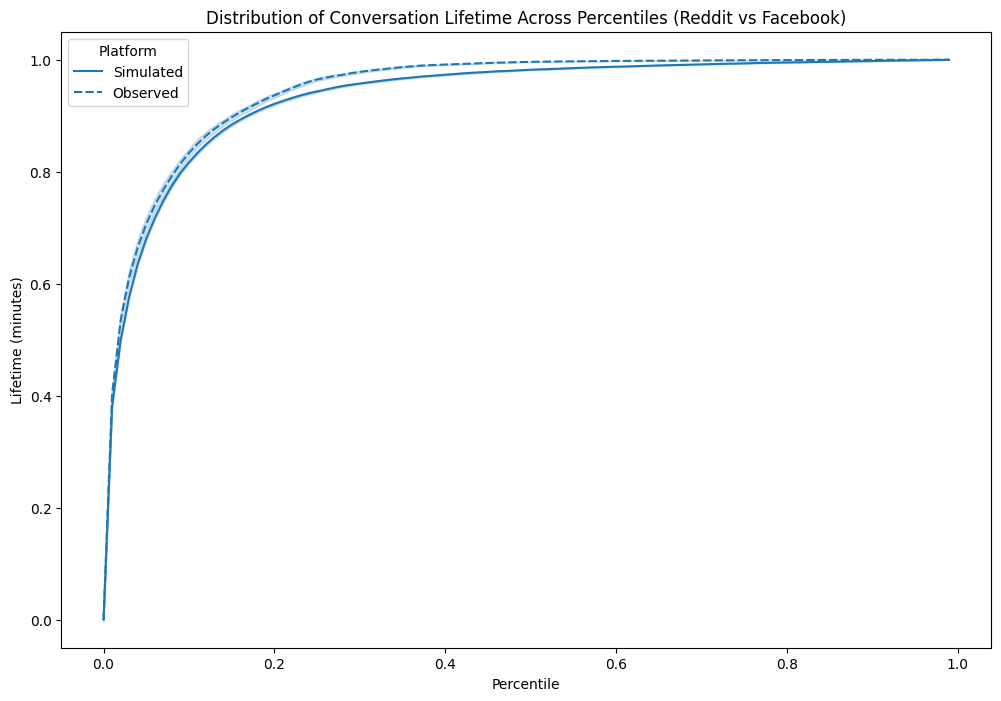

In [98]:
combined_results = pd.concat([simulated_ECDF, observed_ECDF], ignore_index=True)
df=combined_results
# Plotting lineplot for both Reddit and Facebook with confidence intervals
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Time Grid Value', y='Share',style='Platform', errorbar=('ci', 99))
#sns.lineplot(data=combined_results, x='Time Grid Value', y='Share_cc', hue='Platform', errorbar=('ci', 99))
plt.title('Distribution of Conversation Lifetime Across Percentiles (Reddit vs Facebook)')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()


## Global comparison

In [106]:
social_platforms = [fb, rd, yt, vo]
n = 100

# Assuming `params_dict` contains the parameters for each social platform
for i,social in enumerate(social_platforms):
    parameters = params_dict[nomi_dei_social[i]]

    a = parameters['a']
    b = parameters['b']
    loc = parameters['loc']
    scale = parameters['scale']

    alpha = parameters['alpha']
    lambda_ = parameters['lambda']

    c = parameters['c']
    d = parameters['d']
    l = parameters['l']
    s = parameters['s']

    cf = parameters['cf']
    df = parameters['df']
    lf = parameters['lf']
    sf = parameters['sf']

    simulated, observed = simulate_data(social, a, b, loc, scale, alpha, lambda_, c, d, l, s, cf, df, lf, sf)

    # Dynamically assign the simulated and observed data to variables
    globals()[f'simulated_{nomi_dei_social[i]}'] = simulated
    globals()[f'observed_{nomi_dei_social[i]}'] = observed


100%|██████████| 100/100 [00:00<00:00, 180.64it/s]


In [117]:
simulated_fb_ECDF = calculate_ECDF(simulated_fb, time_intervals)
simulated_fb_ECDF['Platform']='Facebook'
simulated_fb_ECDF['Type']='Simulated'
observed_fb_ECDF = calculate_ECDF(observed_fb, time_intervals)
observed_fb_ECDF['Platform']='Facebook'
observed_fb_ECDF['Type']='Observed'

simulated_yt_ECDF = calculate_ECDF(simulated_yt, time_intervals)
simulated_yt_ECDF['Platform']='YouTube'
simulated_yt_ECDF['Type']='Simulated'
observed_yt_ECDF = calculate_ECDF(observed_yt, time_intervals)
observed_yt_ECDF['Platform']='YouTube'
observed_yt_ECDF['Type']='Observed'

simulated_rd_ECDF = calculate_ECDF(simulated_rd, time_intervals)
simulated_rd_ECDF['Platform']='Reddit'
simulated_rd_ECDF['Type']='Simulated'
observed_rd_ECDF = calculate_ECDF(observed_rd, time_intervals)
observed_rd_ECDF['Platform']='Reddit'
observed_rd_ECDF['Type']='Observed'

simulated_vo_ECDF = calculate_ECDF(simulated_vo, time_intervals)
simulated_vo_ECDF['Platform']='Voat'
simulated_vo_ECDF['Type']='Simulated'
observed_vo_ECDF = calculate_ECDF(observed_vo, time_intervals)
observed_vo_ECDF['Platform']='Voat'
observed_vo_ECDF['Type']='Observed'


combined_results = pd.concat([simulated_fb_ECDF, observed_fb_ECDF,simulated_yt_ECDF,observed_yt_ECDF,simulated_rd_ECDF,observed_rd_ECDF,simulated_vo_ECDF,observed_vo_ECDF], ignore_index=True)


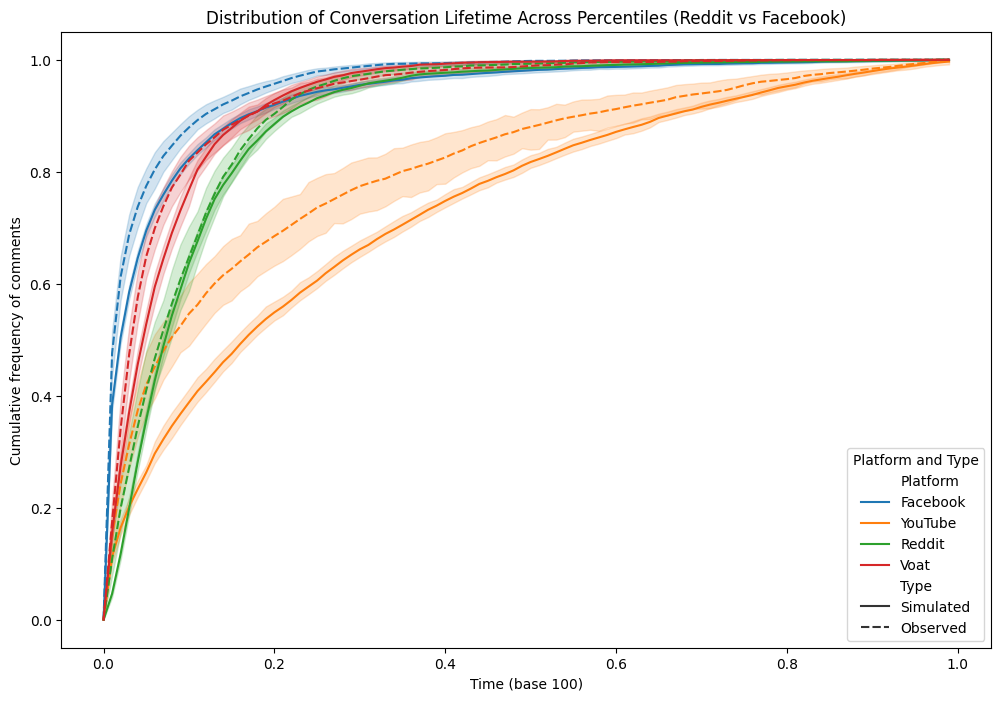

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns


combined_results = pd.concat([simulated_fb_ECDF, observed_fb_ECDF, simulated_rd_ECDF, observed_rd_ECDF], ignore_index=True)
combined_results = pd.concat([simulated_fb_ECDF, observed_fb_ECDF,simulated_yt_ECDF,observed_yt_ECDF,simulated_rd_ECDF,observed_rd_ECDF,simulated_vo_ECDF,observed_vo_ECDF], ignore_index=True)

df = combined_results
plt.figure(figsize=(12, 8))


line1 = sns.lineplot(data=df, x='Time Grid Value', y='Share', style='Type', hue='Platform', errorbar=('ci', 99))
#line2 = sns.lineplot(data=df, x='Time Grid Value', y='Share_cc', style='Type', hue='Platform', errorbar=('ci', 99))


handles1, labels1 = line1.get_legend_handles_labels()
handles2, labels2 = line2.get_legend_handles_labels()

handles, labels = [], []
for handle, label in zip(handles1 + handles2, labels1 + labels2):
    if label not in labels:
        handles.append(handle)
        labels.append(label)

plt.title('Distribution of Conversation Lifetime Across Percentiles (Reddit vs Facebook)')
plt.ylabel('Cumulative frequency of comments')
plt.xlabel('Time (base 100h)')
plt.grid(False)
plt.legend(handles=handles, labels=labels, title='Platform and Type')
plt.show()


#### Just observed

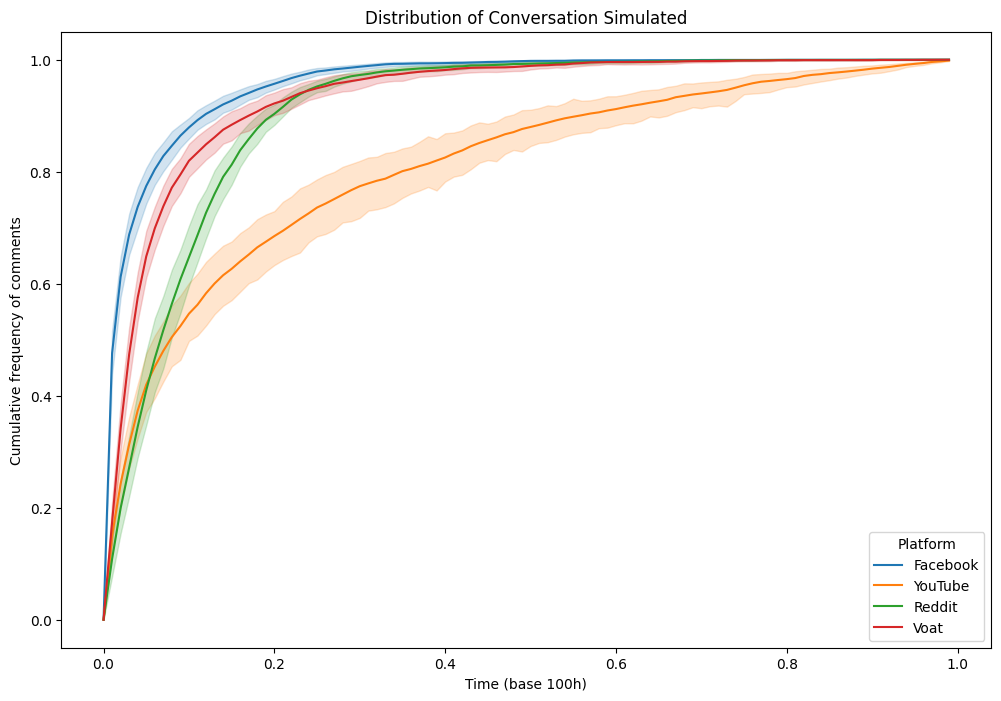

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns


combined_results = pd.concat([simulated_fb_ECDF, observed_fb_ECDF, simulated_rd_ECDF, observed_rd_ECDF], ignore_index=True)
combined_results = pd.concat([simulated_fb_ECDF, observed_fb_ECDF,simulated_yt_ECDF,observed_yt_ECDF,simulated_rd_ECDF,observed_rd_ECDF,simulated_vo_ECDF,observed_vo_ECDF], ignore_index=True)

df = combined_results
plt.figure(figsize=(12, 8))

df=df[df['Type']=='Observed']
line1 = sns.lineplot(data=df, x='Time Grid Value', y='Share', hue='Platform', errorbar=('ci', 99))
#line2 = sns.lineplot(data=df, x='Time Grid Value', y='Share_cc', style='Type', hue='Platform', errorbar=('ci', 99))


handles1, labels1 = line1.get_legend_handles_labels()


handles, labels = [], []
for handle, label in zip(handles1 , labels1 ):
    if label not in labels:
        handles.append(handle)
        labels.append(label)

plt.title('Distribution of Conversation Observed')
plt.ylabel('Cumulative frequency of comments')
plt.xlabel('Time (base 100h)')
plt.grid(False)
plt.legend(handles=handles, labels=labels, title='Platform')
plt.show()


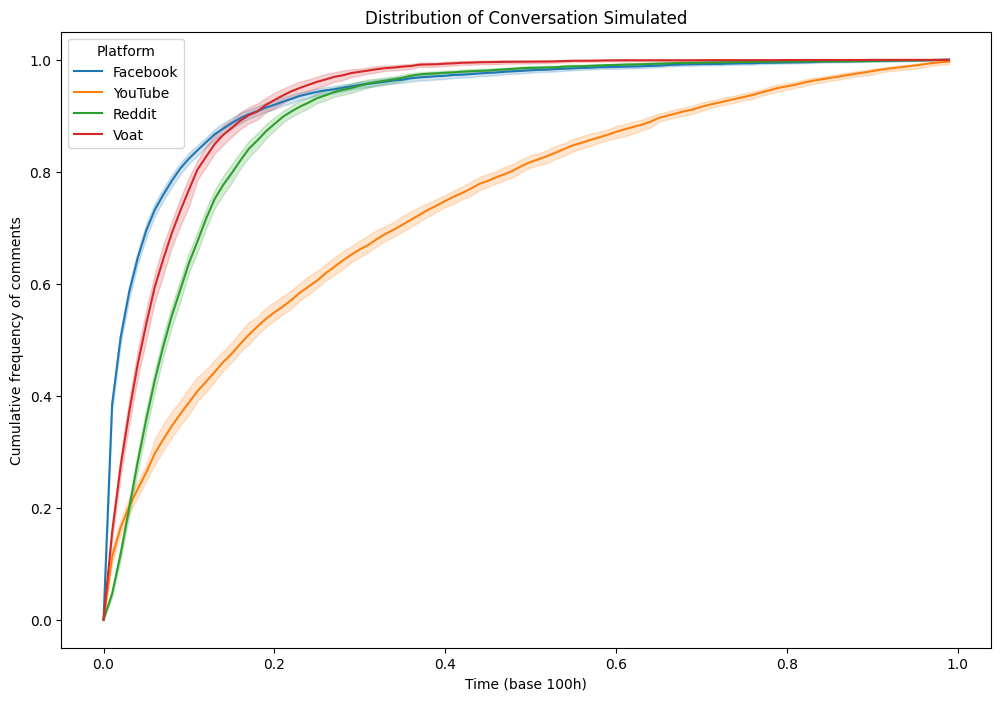

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns


combined_results = pd.concat([simulated_fb_ECDF, observed_fb_ECDF, simulated_rd_ECDF, observed_rd_ECDF], ignore_index=True)
combined_results = pd.concat([simulated_fb_ECDF, observed_fb_ECDF,simulated_yt_ECDF,observed_yt_ECDF,simulated_rd_ECDF,observed_rd_ECDF,simulated_vo_ECDF,observed_vo_ECDF], ignore_index=True)

df = combined_results
plt.figure(figsize=(12, 8))

df=df[df['Type']=='Simulated']
line1 = sns.lineplot(data=df, x='Time Grid Value', y='Share', hue='Platform', errorbar=('ci', 99))
#line2 = sns.lineplot(data=df, x='Time Grid Value', y='Share_cc', style='Type', hue='Platform', errorbar=('ci', 99))


handles1, labels1 = line1.get_legend_handles_labels()


handles, labels = [], []
for handle, label in zip(handles1 , labels1 ):
    if label not in labels:
        handles.append(handle)
        labels.append(label)

plt.title('Distribution of Conversation Simulated')
plt.ylabel('Cumulative frequency of comments')
plt.xlabel('Time (base 100h)')
plt.grid(False)
plt.legend(handles=handles, labels=labels, title='Platform')
plt.show()



## Analysis of parameters

#### T0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Generiamo una griglia di valori x per il plot
x = np.linspace(0, 1, 1000)

# Calcoliamo la densità di probabilità (PDF) della distribuzione beta
pdf_beta1 = beta.pdf(x, 0.49, 1.85)
pdf_beta2 = beta.pdf(x, 0.5, 5.5)
pdf_beta3 = beta.pdf(x, 0.8, 14)
pdf_beta4 = beta.pdf(x, 1.22, 14.25)

# Plot della distribuzione beta
plt.figure(figsize=(10, 6))
plt.plot(x, pdf_beta1, color='#FF0000', lw=3, label='YouTube')   # Red for YouTube
plt.plot(x, pdf_beta2, color='#1877F2', lw=3, label='Facebook')  # Facebook blue
plt.plot(x, pdf_beta3, color='grey', lw=3, label='Voat')      # Orange for Voat
plt.plot(x, pdf_beta4, color='#FF5700', lw=3, label='Reddit')    # Reddit orange-red

plt.xlabel('x')
plt.ylabel('Densità di Probabilità')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Grid Search

In [ ]:
import itertools
import pandas as pd

# Definisci i parametri per ciascuna piattaforma
facebook_params = [0.5, 11, 0.98, 4, 0.1, 0.005, 1.01]
reddit_params = [0.9, 13, 0.85, 5, 0.013, 0.01, 1.22]
youtube_params = [0.95, 12, 0.9, 4, 0.14, 0.03, 1.5]

# Metti insieme tutti i parametri
all_params = [facebook_params, reddit_params, youtube_params]


# Initialize an empty list to store results
results = []

# Time intervals (placeholder, da definire)
time_intervals = np.arange(0, 1, 0.01)  # Utilizzo di np.arange per intervalli decimali


# Loop over each parameter combination
for params in all_params:
    # Unpack the parameters
    a, b, alpha, lambda_, mu, sd, k = params

    # Simulate synthetic data
    simulated, observed = simulate_data(fb, alpha, lambda_, mu, sd, a, b, k, num_threads=100)

    # Calculate ECDFs
    simulated_ECDF = calculate_ECDF(simulated, time_intervals)
    simulated_ECDF['Platform'] = 'Simulated'
    observed_ECDF = calculate_ECDF(observed, time_intervals)
    observed_ECDF['Platform'] = 'Observed'

    # Calculate error
    error = calculate_loss(simulated_ECDF, observed_ECDF)

    # Append results tuple to list
    results.append((*params, error))

# Convert results list to DataFrame
results_df = pd.DataFrame(results, columns=['a', 'b', 'alpha', 'lambda_', 'mu', 'sd', 'k', 'Error'])

print(results_df)


,a,b,alpha,lambda_,mu,sd,k,Error
0,0.50,11,0.98,4,0.100,0.005,1.01,319.061252
1,0.90,13,0.85,5,0.013,0.010,1.22,539.726110
2,0.95,12,0.90,4,0.140,0.030,1.50,1424.112921


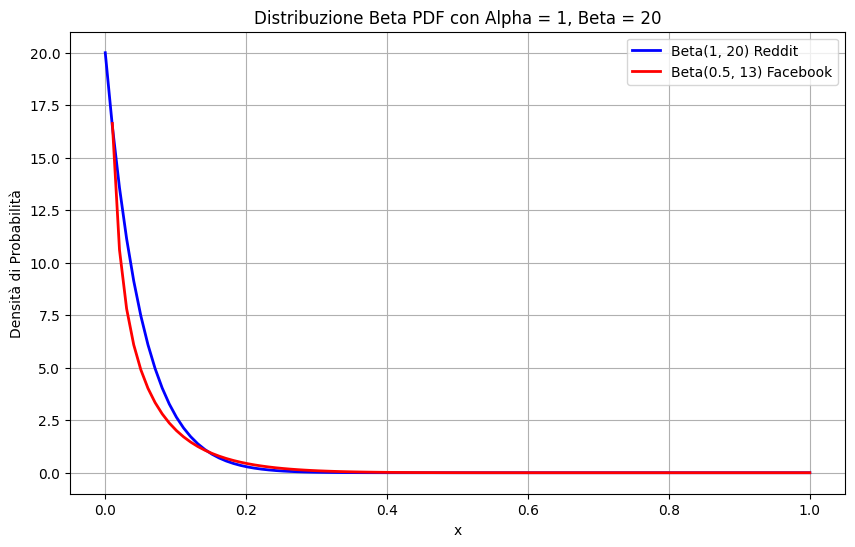

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Parametri della distribuzione beta
alpha =1
beta_param = 20

# Generiamo una griglia di valori x per il plot
x = np.linspace(0, 1, 100)

# Calcoliamo la densità di probabilità (PDF) della distribuzione beta
pdf_beta = beta.pdf(x, alpha, beta_param)
pdf_beta2 = beta.pdf(x, 0.5, 11)

# Plot della distribuzione beta
plt.figure(figsize=(10, 6))
plt.plot(x, pdf_beta, 'b-', lw=2, label=f'Beta({alpha}, {beta_param}) Reddit')
plt.plot(x, pdf_beta2, 'r-', lw=2, label=f'Beta({0.5}, {13}) Facebook')
plt.title(f'Distribuzione Beta PDF con Alpha = {alpha}, Beta = {beta_param}')
plt.xlabel('x')
plt.ylabel('Densità di Probabilità')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

# Define social
social = fb

# Define the grid of parameters
parameters = {
    'a': np.arange(0.5, 1.05, 0.2),
    'b': np.arange(10, 14, 1.2),
    'alpha': np.arange(0.8, 1.05, 0.1),
    'lambda_': 4,
    'mu': np.arange(0.1, 0.15, 0.03),
    'sd': np.arange(0.005, 0.03, 0.01),
    'k': np.arange(1, 1.6, 0.3)
}

# Initialize an empty list to store results
results = []
time_intervals = np.arange(0, 1, 0.1)  # Utilizzo di np.arange per intervalli decimali

# Generate all combinations of parameters
param_combinations = list(itertools.product(*parameters.values()))

# Define a function to process each combination
def process_combination(params):
    # Unpack the parameters
    a, b, alpha, lambda_, mu, sd, k = params

    # Simulate synthetic data
    simulated, observed = simulate_data(social, alpha, lambda_, mu, sd, a, b, k, num_threads=10, activate_tqdm=False)

    # Calculate ECDFs
    simulated_ECDF = calculate_ECDF(simulated, time_intervals, activate_tqdm=False)
    simulated_ECDF['Platform'] = 'Simulated'
    observed_ECDF = calculate_ECDF(observed, time_intervals, activate_tqdm=False)
    observed_ECDF['Platform'] = 'Observed'

    # Calculate error
    error = calculate_loss(simulated_ECDF, observed_ECDF)

    # Return results tuple
    return (*params, error)

# Use ProcessPoolExecutor for parallel processing
with ProcessPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_combination, param_combinations), total=len(param_combinations)))

# Convert results list to DataFrame
results_df = pd.DataFrame(results, columns=['a', 'b', 'alpha', 'lambda_', 'mu', 'sd', 'k', 'Error'])

# Optional: Save results to a file
# results_df.to_csv('results.csv', index=False)


  0%|          | 4/1728 [00:26<3:13:16,  6.73s/it]


KeyboardInterrupt: 

In [ ]:
import itertools

# Define social
social=rd

# Define the grid of parameters
parameters = {
    'a': [ 0.1,0.3,0.5,1,2,3],
    'b': [5,10,15, 20, 25,30,35],
    'alpha': [1,0.95,0.9,0.8,0.75],
    'lambda_': [1,4,8,13],
    'mu': [0.002],
    'sd': [0.001],
    'k': [1.0]
}

# Initialize an empty list to store results
results = []

# Generate all combinations of parameters
param_combinations = list(itertools.product(*parameters.values()))

# Loop over each parameter combination
for params in (param_combinations):
    # Unpack the parameters
    a, b, alpha, lambda_, mu, sd, k = params

    # Simulate synthetic data
    simulated, observed = simulate_data(social, alpha, lambda_, mu, sd, a, b, k, num_threads=10)

    # Calculate ECDFs
    simulated_ECDF = calculate_ECDF(simulated, time_intervals)
    simulated_ECDF['Platform'] = 'Simulated'
    observed_ECDF = calculate_ECDF(observed, time_intervals)
    observed_ECDF['Platform'] = 'Observed'

    # Calculate error
    error = calculate_loss(simulated_ECDF, observed_ECDF)

    # Append results tuple to list
    results.append((*params, error))


# Convert results list to DataFrame
results_df = pd.DataFrame(results, columns=['a', 'b', 'alpha', 'lambda_', 'mu', 'sd', 'k', 'Error'])




 50%|█████     | 5/10 [00:00<00:00,  6.61it/s]


KeyboardInterrupt: 

In [ ]:
import itertools

# Define social
social=yt

# Define the grid of parameters
parameters = {
    'a': [ 0.1,0.3,0.5,0.7,1,2],
    'b': [5,7,15, 20,25,30],
    'alpha': [0.7],
    'lambda_': [4],
    'mu': [0.02],
    'sd': [0.001],
    'k': [1.0]
}

# Initialize an empty list to store results
results = []

# Generate all combinations of parameters
param_combinations = list(itertools.product(*parameters.values()))

# Loop over each parameter combination
for params in (param_combinations):
    # Unpack the parameters
    a, b, alpha, lambda_, mu, sd, k = params

    # Simulate synthetic data
    simulated, observed = simulate_data(social, alpha, lambda_, mu, sd, a, b, k, num_threads=5)

    # Calculate ECDFs
    simulated_ECDF = calculate_ECDF(simulated, time_intervals)
    simulated_ECDF['Platform'] = 'Simulated'
    observed_ECDF = calculate_ECDF(observed, time_intervals)
    observed_ECDF['Platform'] = 'Observed'

    # Calculate error
    error = calculate_loss(simulated_ECDF, observed_ECDF)

    # Append results tuple to list
    results.append((*params, error))


# Convert results list to DataFrame
results_df = pd.DataFrame(results, columns=['a', 'b', 'alpha', 'lambda_', 'mu', 'sd', 'k', 'Error'])




,a,b,alpha,lambda_,mu,sd,k,Error
0,0.1,5,0.7,4,0.02,0.001,1.0,65.303787
1,0.1,7,0.7,4,0.02,0.001,1.0,67.229143
2,0.1,15,0.7,4,0.02,0.001,1.0,70.231330
3,0.1,20,0.7,4,0.02,0.001,1.0,70.314775
4,0.1,25,0.7,4,0.02,0.001,1.0,72.431185
5,0.1,30,0.7,4,0.02,0.001,1.0,71.795799
6,0.3,5,0.7,4,0.02,0.001,1.0,47.800080
7,0.3,7,0.7,4,0.02,0.001,1.0,56.481084
8,0.3,15,0.7,4,0.02,0.001,1.0,64.180301
9,0.3,20,0.7,4,0.02,0.001,1.0,67.621112
